##### How can user review/feedback be effectively grouped to identify key areas for app improvement? / Can we Identify common technical issues and feature request based on user reviews to improve the application user experience?

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [141]:
df = pd.read_csv('gcash-2020-formatted.csv')

In [142]:
df.head()

,Unnamed: 0.1,Unnamed: 0,review_text,review_rating,review_datetime_utc,review_likes,review_text_formatted
0,57770,57770,Please fix your app bug. It has been to weeks ...,2,2020-01-01T00:04:48.000Z,1,"['please', 'fix', 'application', 'bug', 'week'..."
1,57771,57771,I always wanted to cash in for me to use it on...,1,2020-01-01T00:45:51.000Z,0,"['always', 'want', 'cash', 'use', 'billing', '..."
2,57774,57774,Pahelp nmn po dq maaus yung gcash mpin q dhil ...,1,2020-01-01T02:09:35.000Z,0,"['pahelp', 'po', 'dq', 'maaus', 'gcash', 'mpin..."
3,57776,57776,SINCE NOVEMBER UNTIL NOW I CANNOT CASH IN. BEE...,1,2020-01-01T02:47:23.000Z,0,"['since', 'November', 'negativelabel', 'cash',..."
4,57781,57781,Make me disappointed this app when i try to op...,1,2020-01-01T03:51:08.000Z,0,"['make', 'disappointed', 'application', 'try',..."


# Data Pre-Processing

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33249 entries, 0 to 33248
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Unnamed: 0.1           33249 non-null  int64 
 1   Unnamed: 0             33249 non-null  int64 
 2   review_text            33249 non-null  object
 3   review_rating          33249 non-null  int64 
 4   review_datetime_utc    33249 non-null  object
 5   review_likes           33249 non-null  int64 
 6   review_text_formatted  33249 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.8+ MB


In [144]:
print(df.isna().sum())

Unnamed: 0.1             0
Unnamed: 0               0
review_text              0
review_rating            0
review_datetime_utc      0
review_likes             0
review_text_formatted    0
dtype: int64


In [145]:
print(df['review_rating'].value_counts())

review_rating
1    13107
5    11401
3     3200
2     2806
4     2735
Name: count, dtype: int64


In [146]:
df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0','review_datetime_utc'], inplace=True)
df.dropna(inplace=True)

In [147]:
df.head()

,review_text,review_rating,review_likes,review_text_formatted
0,Please fix your app bug. It has been to weeks ...,2,1,"['please', 'fix', 'application', 'bug', 'week'..."
1,I always wanted to cash in for me to use it on...,1,0,"['always', 'want', 'cash', 'use', 'billing', '..."
2,Pahelp nmn po dq maaus yung gcash mpin q dhil ...,1,0,"['pahelp', 'po', 'dq', 'maaus', 'gcash', 'mpin..."
3,SINCE NOVEMBER UNTIL NOW I CANNOT CASH IN. BEE...,1,0,"['since', 'November', 'negativelabel', 'cash',..."
4,Make me disappointed this app when i try to op...,1,0,"['make', 'disappointed', 'application', 'try',..."


In [148]:
import re

df['review_text_formatted'] = df['review_text_formatted'].apply(
    lambda x: re.sub(r"[\[\]']", '', x)  # Removes [, ], and ' characters
)

df['review_text_formatted'] = df['review_text_formatted'].apply(
    lambda x: x.replace(',', '') if isinstance(x, str) else x
)

In [149]:
df.head()

,review_text,review_rating,review_likes,review_text_formatted
0,Please fix your app bug. It has been to weeks ...,2,1,please fix application bug week still transfer...
1,I always wanted to cash in for me to use it on...,1,0,always want cash use billing load everytime go...
2,Pahelp nmn po dq maaus yung gcash mpin q dhil ...,1,0,pahelp po dq maaus gcash mpin dhil pinakialamn...
3,SINCE NOVEMBER UNTIL NOW I CANNOT CASH IN. BEE...,1,0,since November negativelabel cash receive msg ...
4,Make me disappointed this app when i try to op...,1,0,make disappointed application try open gcash a...


In [150]:
print(df.duplicated(subset=['review_text_formatted']).sum())
df = df.drop_duplicates(subset=['review_text_formatted'])

1992


# Exploratory Data Analysis

Top 20 Most Frequent Words in Reviews

In [151]:
word_list = df['review_text_formatted'].str.split().explode()  # Flatten tokenized words
word_freq = Counter(word_list)

# View top 20 words
print(word_freq.most_common(20))

[('negativelabel', 20698), ('application', 11934), ('gcash', 8450), ('use', 6279), ('update', 4774), ('money', 4469), ('account', 3906), ('load', 3536), ('verify', 3518), ('good', 3331), ('id', 3064), ('please', 2965), ('time', 2898), ('need', 2857), ('always', 2643), ('transaction', 2474), ('cash', 2443), ('easy', 2397), ('send', 2271), ('pay', 2269)]


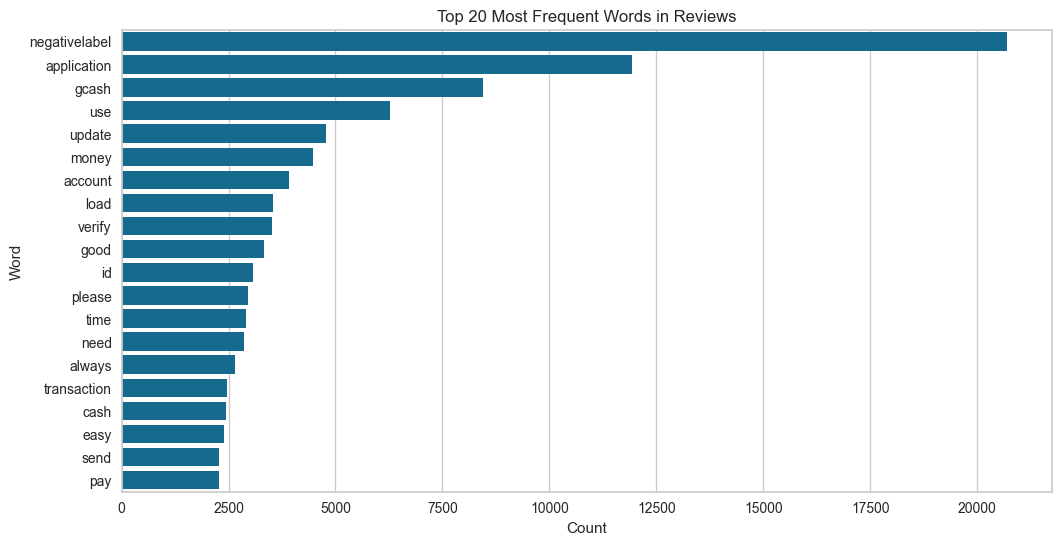

In [152]:
top_words = pd.DataFrame(word_freq.most_common(20), columns=['Word', 'Count'])

plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Word', data=top_words)
plt.title("Top 20 Most Frequent Words in Reviews")
plt.show()


Distribution of Review Lengths

In [153]:
df['text_length'] = df['review_text_formatted'].apply(lambda x: len(x.split()))
print(df['text_length'].describe())  # Summary stats

count    31257.000000
mean        10.983908
std          9.503894
min          3.000000
25%          4.000000
50%          8.000000
75%         14.000000
max         68.000000
Name: text_length, dtype: float64


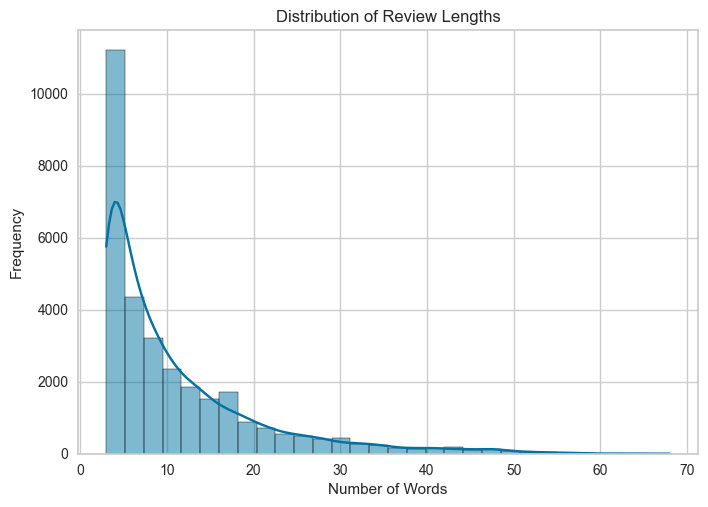

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['text_length'], bins=30, kde=True)
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.title("Distribution of Review Lengths")
plt.show()

df.drop(columns=['text_length'], inplace=True)

# Feature Representation

In [155]:
df.head()

,review_text,review_rating,review_likes,review_text_formatted
0,Please fix your app bug. It has been to weeks ...,2,1,please fix application bug week still transfer...
1,I always wanted to cash in for me to use it on...,1,0,always want cash use billing load everytime go...
2,Pahelp nmn po dq maaus yung gcash mpin q dhil ...,1,0,pahelp po dq maaus gcash mpin dhil pinakialamn...
3,SINCE NOVEMBER UNTIL NOW I CANNOT CASH IN. BEE...,1,0,since November negativelabel cash receive msg ...
4,Make me disappointed this app when i try to op...,1,0,make disappointed application try open gcash a...


In [156]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
X = vectorizer.fit_transform(df['review_text_formatted']).toarray()

In [157]:
df_tfidf = pd.DataFrame(X, columns=vectorizer.get_feature_names_out())
print(df_tfidf)

       100x  10x  15th  1hour  1st  1star  1week  24hr  2day  2nd  ...  you  \
0       0.0  0.0   0.0    0.0  0.0    0.0    0.0   0.0   0.0  0.0  ...  0.0   
1       0.0  0.0   0.0    0.0  0.0    0.0    0.0   0.0   0.0  0.0  ...  0.0   
2       0.0  0.0   0.0    0.0  0.0    0.0    0.0   0.0   0.0  0.0  ...  0.0   
3       0.0  0.0   0.0    0.0  0.0    0.0    0.0   0.0   0.0  0.0  ...  0.0   
4       0.0  0.0   0.0    0.0  0.0    0.0    0.0   0.0   0.0  0.0  ...  0.0   
...     ...  ...   ...    ...  ...    ...    ...   ...   ...  ...  ...  ...   
31252   0.0  0.0   0.0    0.0  0.0    0.0    0.0   0.0   0.0  0.0  ...  0.0   
31253   0.0  0.0   0.0    0.0  0.0    0.0    0.0   0.0   0.0  0.0  ...  0.0   
31254   0.0  0.0   0.0    0.0  0.0    0.0    0.0   0.0   0.0  0.0  ...  0.0   
31255   0.0  0.0   0.0    0.0  0.0    0.0    0.0   0.0   0.0  0.0  ...  0.0   
31256   0.0  0.0   0.0    0.0  0.0    0.0    0.0   0.0   0.0  0.0  ...  0.0   

       young  your  youtube  ypu  yun  zero  zolo  

In [158]:
print(f"Original DataFrame shape: {df.shape}")
print(f"TF-IDF matrix shape: {X.shape}")

Original DataFrame shape: (31257, 4)
TF-IDF matrix shape: (31257, 3198)


In [159]:
df.head()

,review_text,review_rating,review_likes,review_text_formatted
0,Please fix your app bug. It has been to weeks ...,2,1,please fix application bug week still transfer...
1,I always wanted to cash in for me to use it on...,1,0,always want cash use billing load everytime go...
2,Pahelp nmn po dq maaus yung gcash mpin q dhil ...,1,0,pahelp po dq maaus gcash mpin dhil pinakialamn...
3,SINCE NOVEMBER UNTIL NOW I CANNOT CASH IN. BEE...,1,0,since November negativelabel cash receive msg ...
4,Make me disappointed this app when i try to op...,1,0,make disappointed application try open gcash a...


In [160]:
df_copy = df.copy()

In [161]:
df = pd.concat([df, df_tfidf], axis=1)

In [162]:
df.head()

,review_text,review_rating,review_likes,review_text_formatted,100x,10x,15th,1hour,1st,1star,...,you,young,your,youtube,ypu,yun,zero,zolo,zoloz,zoom
0,Please fix your app bug. It has been to weeks ...,2.0,1.0,please fix application bug week still transfer...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,I always wanted to cash in for me to use it on...,1.0,0.0,always want cash use billing load everytime go...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Pahelp nmn po dq maaus yung gcash mpin q dhil ...,1.0,0.0,pahelp po dq maaus gcash mpin dhil pinakialamn...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,SINCE NOVEMBER UNTIL NOW I CANNOT CASH IN. BEE...,1.0,0.0,since November negativelabel cash receive msg ...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Make me disappointed this app when i try to op...,1.0,0.0,make disappointed application try open gcash a...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Principal Component Analysis

In [163]:
df.drop(columns=['review_text_formatted', 'review_likes', 'review_rating', 'review_text'], inplace=True)

In [164]:
df.head()

,100x,10x,15th,1hour,1st,1star,1week,24hr,2day,2nd,...,you,young,your,youtube,ypu,yun,zero,zolo,zoloz,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [165]:
print(df.isna().sum())

100x     1811
10x      1811
15th     1811
1hour    1811
1st      1811
         ... 
yun      1811
zero     1811
zolo     1811
zoloz    1811
zoom     1811
Length: 3198, dtype: int64


In [166]:
df.dropna(inplace=True)
print(df.isna().sum())

100x     0
10x      0
15th     0
1hour    0
1st      0
        ..
yun      0
zero     0
zolo     0
zoloz    0
zoom     0
Length: 3198, dtype: int64


In [167]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=1000)  # Try 300 first
X_svd = svd.fit_transform(df)  # X is your TF-IDF matrix

print("Original shape:", df.shape)
print("Reduced shape:", X_svd.shape)

Original shape: (31257, 3198)
Reduced shape: (31257, 1000)


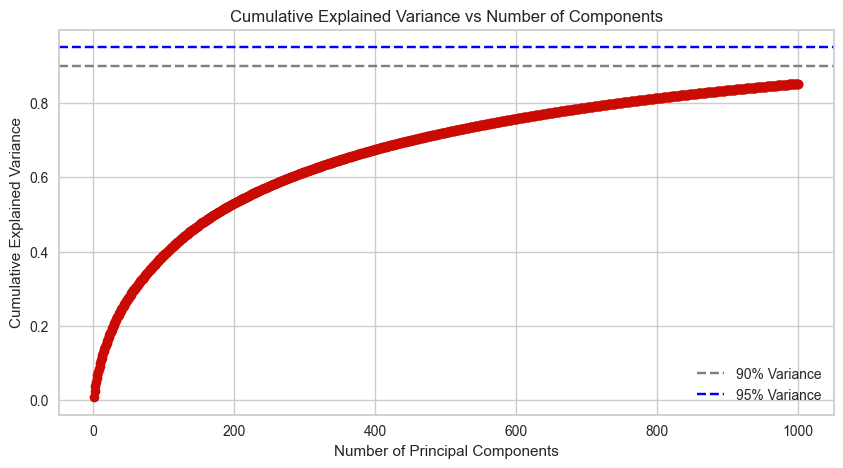

In [168]:
explained_variance = svd.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 1001), cumulative_variance, marker='o', linestyle='-', color='r')

# Add Threshold Lines
plt.axhline(y=0.90, color='gray', linestyle='--', label='90% Variance')
plt.axhline(y=0.95, color='blue', linestyle='--', label='95% Variance')

plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.legend()
plt.grid(True)

plt.show()

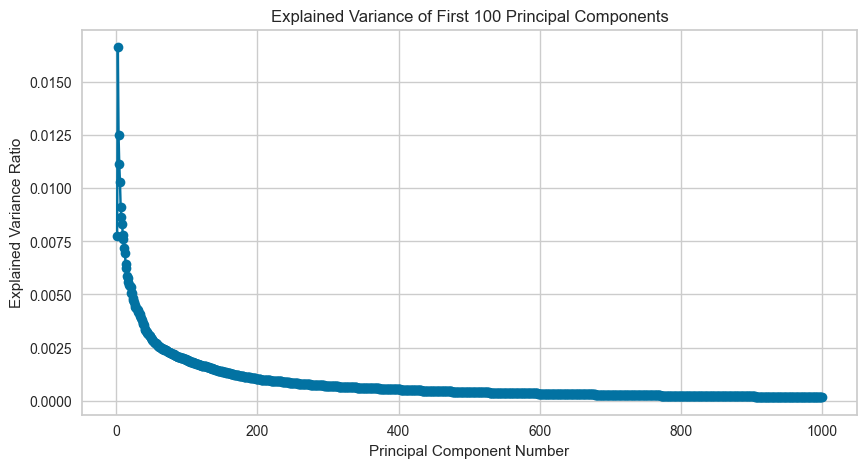

In [169]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, 1001), explained_variance, marker='o', linestyle='-', color='b')

plt.xlabel('Principal Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance of First 100 Principal Components')
plt.grid(True)

plt.show()

# Kmeans Clustering

Elbow Method to determine the number of clusters to be formed:


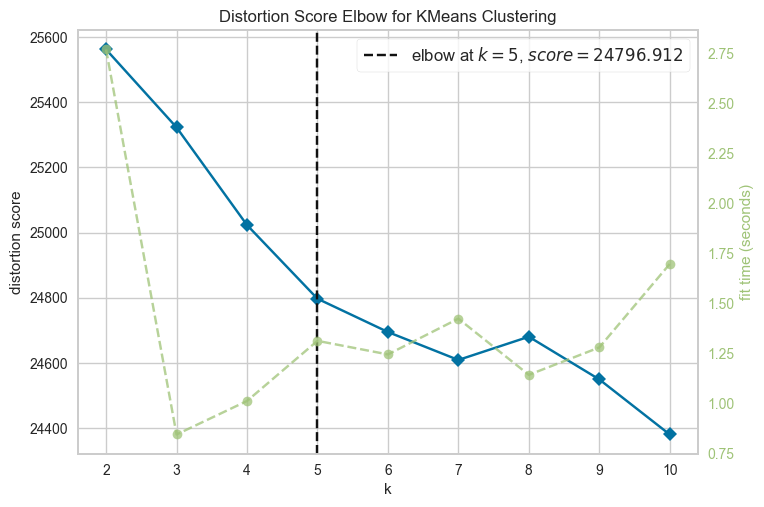

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [170]:
from yellowbrick.cluster import KElbowVisualizer

print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(max_iter=100, n_init='auto', init='k-means++', random_state=42), k=10)
Elbow_M.fit(X_svd)
Elbow_M.show()

In [171]:
num_clusters = Elbow_M.elbow_value_
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

df['cluster'] = kmeans.fit_predict(X_svd)
kmeans_labels = kmeans.labels_

df_copy['cluster'] = df['cluster']

In [172]:
df_copy.drop(columns=['review_text_formatted', 'review_likes', 'review_rating'], inplace=True)
df_copy.dropna(inplace=True)
df_copy.to_csv("sentence_2020.csv", index=False)
df_copy

,review_text,cluster
0,Please fix your app bug. It has been to weeks ...,4.0
1,I always wanted to cash in for me to use it on...,4.0
2,Pahelp nmn po dq maaus yung gcash mpin q dhil ...,4.0
3,SINCE NOVEMBER UNTIL NOW I CANNOT CASH IN. BEE...,4.0
4,Make me disappointed this app when i try to op...,4.0
...,...,...
31252,Remove the processing fees and other charges. ...,4.0
31253,There should be a maximum amount for the 15php...,4.0
31254,It's hard to sign in pls fix this.,4.0
31255,great we found gcash apps...,4.0



Cluster 0 - TF-IDF Scores:
easy: 0.3748
use: 0.1172
pay: 0.0649
money: 0.0629
application: 0.0610
bill: 0.0550
transaction: 0.0478
make: 0.0466
send: 0.0393
fast: 0.0369


C:\Users\Neil\AppData\Local\Temp\ipykernel_20188\639209166.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=words, palette="viridis")


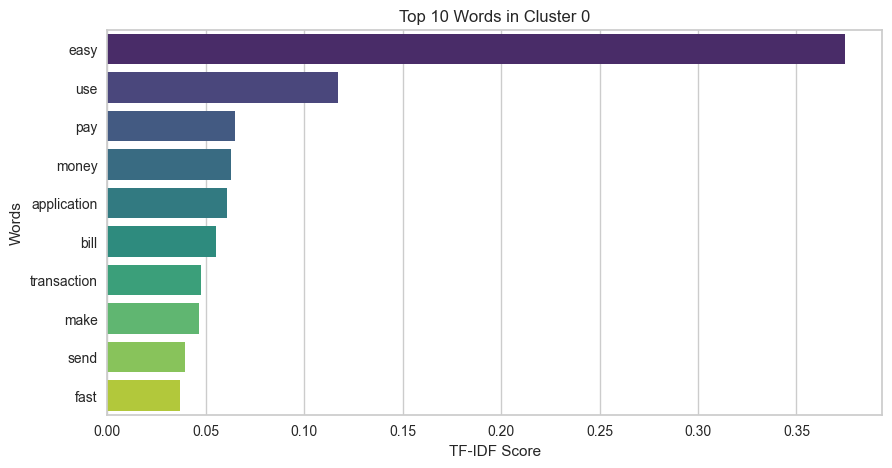


Cluster 1 - TF-IDF Scores:
update: 0.2879
negativelabel: 0.0844
need: 0.0729
application: 0.0714
always: 0.0570
use: 0.0408
open: 0.0406
gcash: 0.0309
time: 0.0306
every: 0.0223


C:\Users\Neil\AppData\Local\Temp\ipykernel_20188\639209166.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=words, palette="viridis")


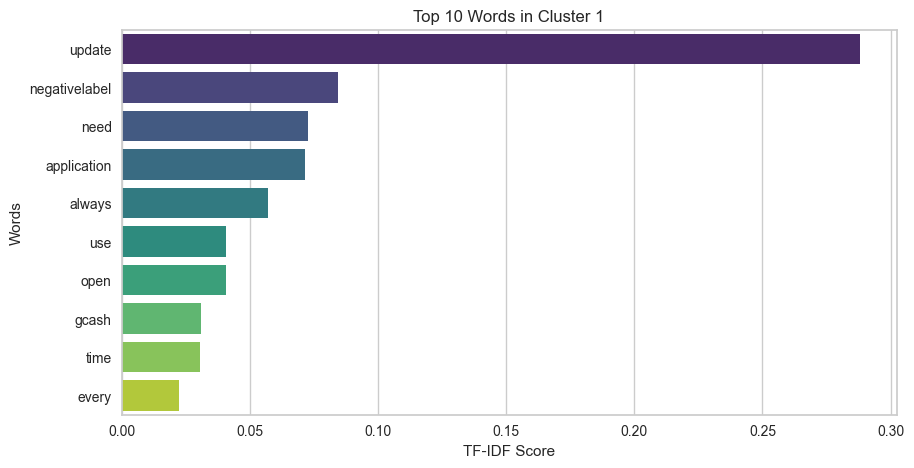


Cluster 2 - TF-IDF Scores:
application: 0.1661
good: 0.1423
nice: 0.0806
love: 0.0459
use: 0.0441
great: 0.0436
gcash: 0.0399
useful: 0.0387
convenient: 0.0266
money: 0.0263


C:\Users\Neil\AppData\Local\Temp\ipykernel_20188\639209166.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=words, palette="viridis")


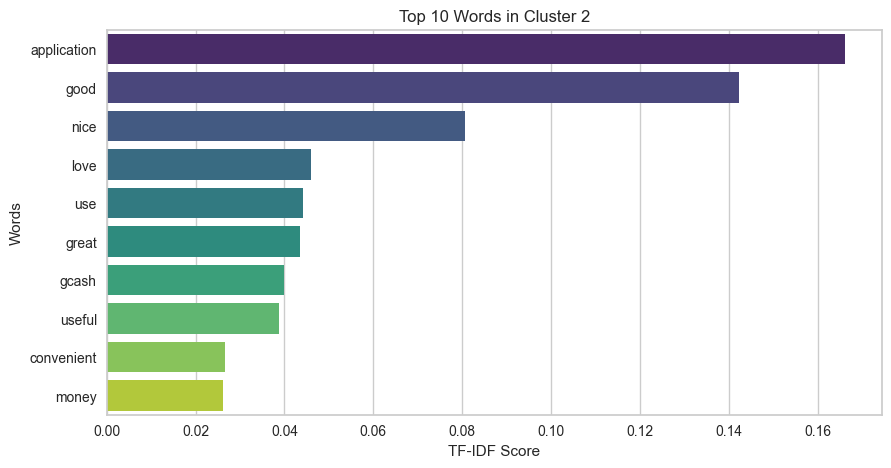


Cluster 3 - TF-IDF Scores:
id: 0.2022
verify: 0.2021
student: 0.1315
negativelabel: 0.1194
account: 0.0884
fully: 0.0833
please: 0.0503
get: 0.0437
verification: 0.0414
valid: 0.0388


C:\Users\Neil\AppData\Local\Temp\ipykernel_20188\639209166.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=words, palette="viridis")


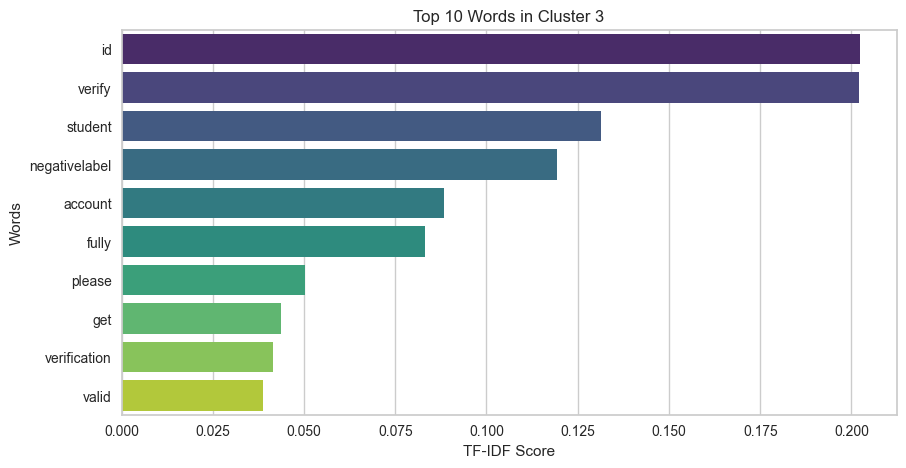


Cluster 4 - TF-IDF Scores:
negativelabel: 0.0686
gcash: 0.0429
application: 0.0275
load: 0.0273
money: 0.0255
use: 0.0244
cash: 0.0208
always: 0.0207
account: 0.0204
please: 0.0193


C:\Users\Neil\AppData\Local\Temp\ipykernel_20188\639209166.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=words, palette="viridis")


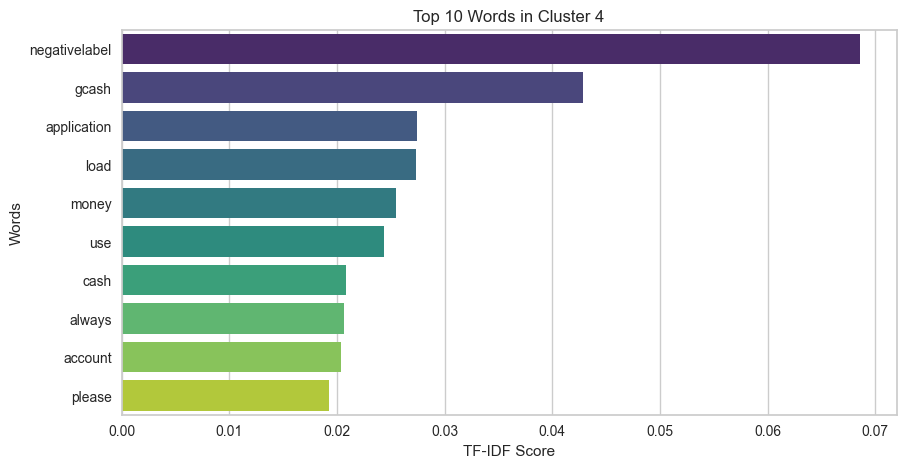

In [173]:
terms = vectorizer.get_feature_names_out()

# Inverse transform cluster centers back to TF-IDF space
approx_tfidf = svd.inverse_transform(kmeans.cluster_centers_)

def plot_top_words(cluster_index, top_n=10):
    if cluster_index >= num_clusters:
        return None
    
    term_frequencies = approx_tfidf[cluster_index]
    
    # Get top N words in this cluster
    sorted_indices = np.argsort(term_frequencies)[::-1][:top_n]
    words = [terms[i] for i in sorted_indices]
    scores = [term_frequencies[i] for i in sorted_indices]

    # Print scores array
    print(f"\nCluster {cluster_index} - TF-IDF Scores:")
    for word, score in zip(words, scores):
        print(f"{word}: {score:.4f}")  # Format to 4 decimal places

    # Plot bar chart
    plt.figure(figsize=(10, 5))
    sns.barplot(x=scores, y=words, palette="viridis")
    plt.xlabel("TF-IDF Score")
    plt.ylabel("Words")
    plt.title(f"Top {top_n} Words in Cluster {cluster_index}")
    plt.show()

# Print & Plot words for each cluster
for i in range(num_clusters):
    plot_top_words(i, top_n=10)


In [174]:
# # Extract feature names (words)
# terms = vectorizer.get_feature_names_out()

# # Ensure df_tfidf is a DataFrame and matches df's shape
# df_tfidf = pd.DataFrame(X, columns=terms)

# # Merge with cluster labels from df (ensuring alignment)
# df_tfidf['cluster'] = df['cluster'].values

# # Compute total TF-IDF scores per word in each cluster
# cluster_word_counts = df_tfidf.groupby('cluster').sum()  # Sum TF-IDF values per cluster

# def plot_top_words(cluster_index, top_n=10):
#     if cluster_index >= num_clusters:
#         return None

#     # Get TF-IDF scores for this cluster
#     term_frequencies = cluster_word_counts.iloc[cluster_index]

#     # Get top N words based on TF-IDF score
#     sorted_indices = term_frequencies.argsort()[::-1][:top_n]
#     words = [terms[i] for i in sorted_indices]
#     scores = [term_frequencies.iloc[i] for i in sorted_indices]
    
#     # Get actual word occurrences from the original dataset
#     counts = df_tfidf[words].sum().values  # Get word counts for selected top words

#     # Plot bar chart
#     plt.figure(figsize=(10, 5))
#     ax = sns.barplot(x=scores, y=words, palette="viridis")

#     # Add text labels for total word counts
#     for i, count in enumerate(counts):
#         ax.text(scores[i], i, f" {int(count)}", va='center', fontsize=10, color='black')

#     plt.xlabel("TF-IDF Score (Summed per Cluster)")
#     plt.ylabel("Words")
#     plt.title(f"Top {top_n} Words in Cluster {cluster_index}")
#     plt.show()

# # Plot words for each cluster
# for i in range(num_clusters):
#     plot_top_words(i, top_n=10)  # Adjust top_n if needed


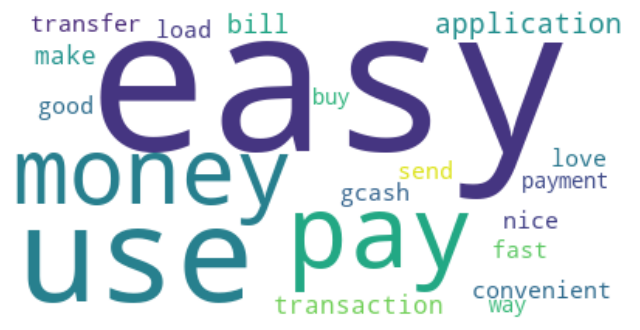

{'easy': np.float64(0.37484522010594146), 'use': np.float64(0.11719004837922449), 'pay': np.float64(0.06487638090708056), 'money': np.float64(0.06294161638845581), 'application': np.float64(0.060968551899181496), 'bill': np.float64(0.05502918728377215), 'transaction': np.float64(0.047828342886503436), 'make': np.float64(0.04661031836804838), 'send': np.float64(0.03931937467086532), 'fast': np.float64(0.036906834151281424), 'convenient': np.float64(0.035978799194946384), 'load': np.float64(0.0346067782547717), 'good': np.float64(0.03391778256811276), 'gcash': np.float64(0.03372328882380918), 'nice': np.float64(0.03324277347743474), 'love': np.float64(0.032241483544358976), 'transfer': np.float64(0.032158846268686925), 'payment': np.float64(0.030002577329568323), 'buy': np.float64(0.02873089698391759), 'way': np.float64(0.028134783857037823)}


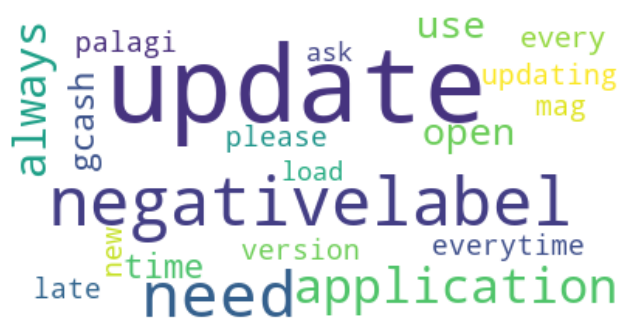

{'update': np.float64(0.28789951043230866), 'negativelabel': np.float64(0.08442808190668229), 'need': np.float64(0.07288384246645165), 'application': np.float64(0.07143442875323266), 'always': np.float64(0.05695404362126975), 'use': np.float64(0.040816714258047275), 'open': np.float64(0.040585310643798174), 'gcash': np.float64(0.030893837980217123), 'time': np.float64(0.03055487641323177), 'every': np.float64(0.02227323416590309), 'palagi': np.float64(0.019690008275545547), 'please': np.float64(0.018922340579515678), 'everytime': np.float64(0.01880398805739898), 'updating': np.float64(0.01805684882869598), 'late': np.float64(0.01782377200750571), 'version': np.float64(0.016894587939996215), 'new': np.float64(0.016536507756936884), 'mag': np.float64(0.015895962408905534), 'ask': np.float64(0.01485757663501065), 'load': np.float64(0.014653508871375547)}


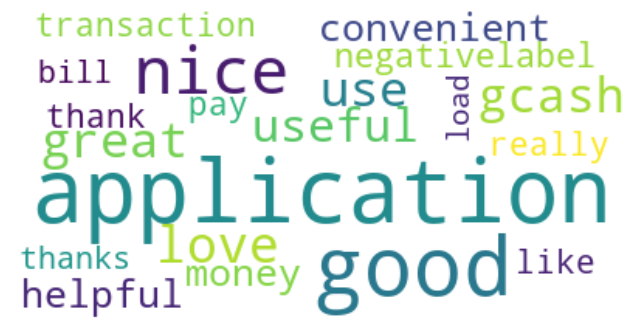

{'application': np.float64(0.16606752606446504), 'good': np.float64(0.14232970148589405), 'nice': np.float64(0.08064827633356969), 'love': np.float64(0.04587476627373), 'use': np.float64(0.04409809389736857), 'great': np.float64(0.04357852210293438), 'gcash': np.float64(0.03988988333463656), 'useful': np.float64(0.03872788701112987), 'convenient': np.float64(0.02664655365258869), 'money': np.float64(0.026252578260416947), 'helpful': np.float64(0.025461224050769376), 'negativelabel': np.float64(0.02531618202405591), 'like': np.float64(0.022357941257477615), 'really': np.float64(0.021723507193592905), 'transaction': np.float64(0.02161129253163805), 'thank': np.float64(0.021553543553912795), 'pay': np.float64(0.021141022239856058), 'thanks': np.float64(0.019688891493564908), 'bill': np.float64(0.019060394523553036), 'load': np.float64(0.017171296996578853)}


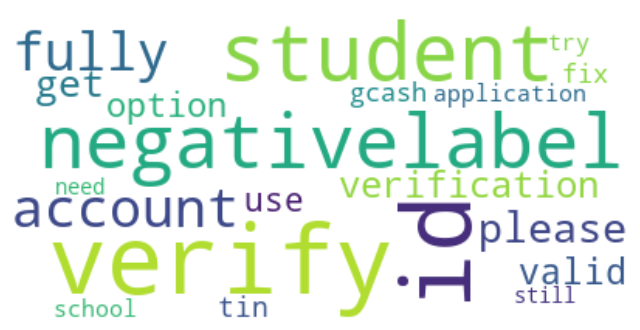

{'id': np.float64(0.20224088582342345), 'verify': np.float64(0.20214478767632), 'student': np.float64(0.1314636057518877), 'negativelabel': np.float64(0.11941081842829514), 'account': np.float64(0.08844084900522578), 'fully': np.float64(0.08327131618384871), 'please': np.float64(0.05034286645284251), 'get': np.float64(0.04370729381375125), 'verification': np.float64(0.04143898099385484), 'valid': np.float64(0.03878467298574117), 'option': np.float64(0.038324954222866144), 'use': np.float64(0.03635572540881737), 'tin': np.float64(0.027167434710878013), 'gcash': np.float64(0.024980699726591407), 'fix': np.float64(0.024828611871408113), 'application': np.float64(0.023090184859766154), 'try': np.float64(0.02283271044555818), 'school': np.float64(0.022821552932939904), 'still': np.float64(0.020274672327010308), 'need': np.float64(0.020114977050252978)}


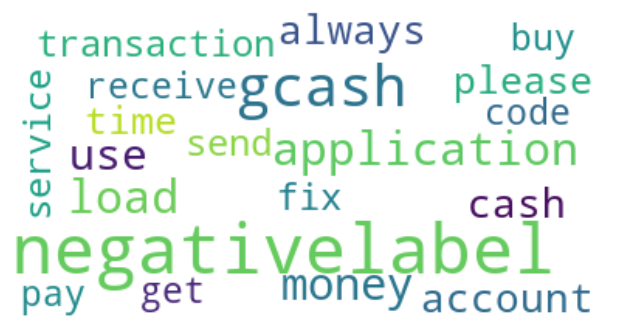

{'negativelabel': np.float64(0.06855640810282645), 'gcash': np.float64(0.04287050060305682), 'application': np.float64(0.027476650025028318), 'load': np.float64(0.027306933099333436), 'money': np.float64(0.02553092920359744), 'use': np.float64(0.024401922682146953), 'cash': np.float64(0.020842697293211254), 'always': np.float64(0.02066931084455678), 'account': np.float64(0.020422540102466), 'please': np.float64(0.019306592143999792), 'time': np.float64(0.018965624643820126), 'transaction': np.float64(0.016947159311098626), 'fix': np.float64(0.016601220099117183), 'service': np.float64(0.01645657827966752), 'send': np.float64(0.016068377926910044), 'buy': np.float64(0.014916092959889186), 'code': np.float64(0.014583857963401633), 'pay': np.float64(0.014374224517184252), 'get': np.float64(0.01411707537143087), 'receive': np.float64(0.014041537728567966)}


In [175]:
# Get original feature names (words)
from wordcloud import WordCloud

def frequencies_dict(cluster_index):
    if cluster_index >= num_clusters:
        return None
    
    term_frequencies = approx_tfidf[cluster_index]
    
    # Get top 20 words in this cluster
    sorted_indices = np.argsort(term_frequencies)[::-1][:20]
    frequencies = {terms[i]: term_frequencies[i] for i in sorted_indices}
    
    return frequencies

def makeImage(frequencies):
    wc = WordCloud(background_color="white", max_words=50)
    wc.generate_from_frequencies(frequencies)

    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

for i in range(num_clusters):
    freq = frequencies_dict(i)
    if freq:
        makeImage(freq)
        print(freq)  # Optional: Print words with weights

# def frequencies_dict(cluster_index, top_n=20):
#     """Return a dictionary of top words and their TF-IDF scores for a given cluster."""
#     if cluster_index >= num_clusters:
#         return None

#     # Get term frequencies (TF-IDF sum per word in the cluster)
#     term_frequencies = cluster_word_counts.iloc[cluster_index]

#     # Get top N words based on TF-IDF score
#     sorted_indices = term_frequencies.argsort()[::-1][:top_n]
#     frequencies = {terms[i]: term_frequencies.iloc[i] for i in sorted_indices}

#     return frequencies

# def makeImage(frequencies):
#     """Generate and display a word cloud from word frequencies."""
#     wc = WordCloud(background_color="white", max_words=50)
#     wc.generate_from_frequencies(frequencies)

#     plt.figure(figsize=(8, 6))
#     plt.imshow(wc, interpolation="bilinear")
#     plt.axis("off")
#     plt.show()

# # Generate word clouds for each cluster
# for i in range(num_clusters):
#     freq = frequencies_dict(i, top_n=20)  # Adjust top_n as needed
#     if freq:
#         makeImage(freq)
#         print(freq)  # Optional: Print words with TF-IDF scores


C:\Users\Neil\AppData\Local\Temp\ipykernel_20188\190333237.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=words, ax=axes[1], palette="viridis")


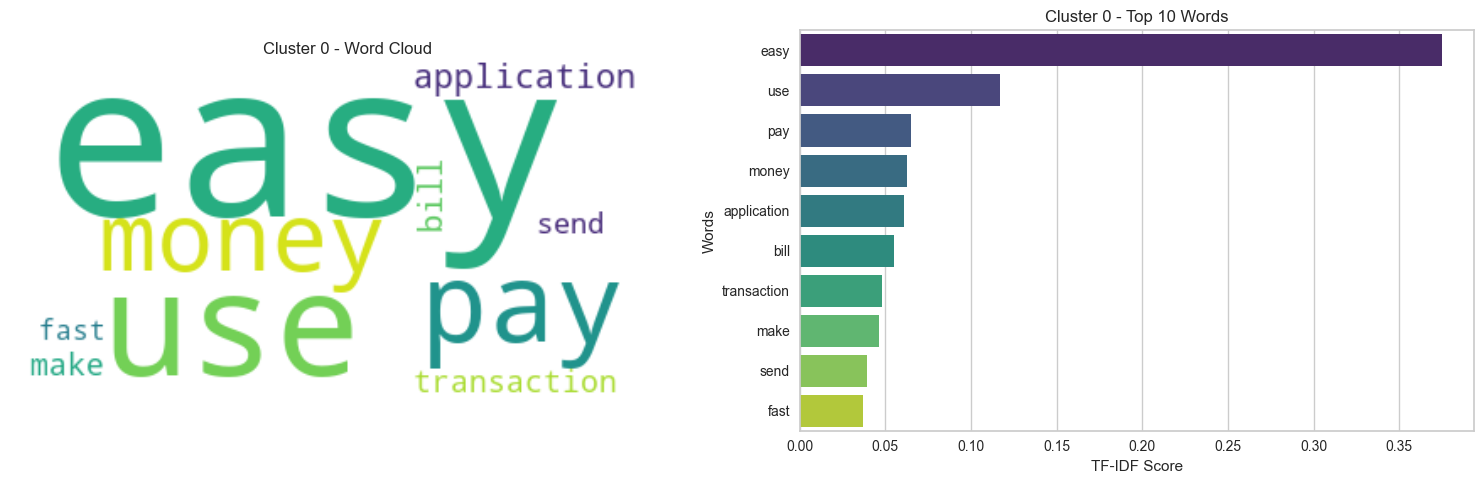

C:\Users\Neil\AppData\Local\Temp\ipykernel_20188\190333237.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=words, ax=axes[1], palette="viridis")


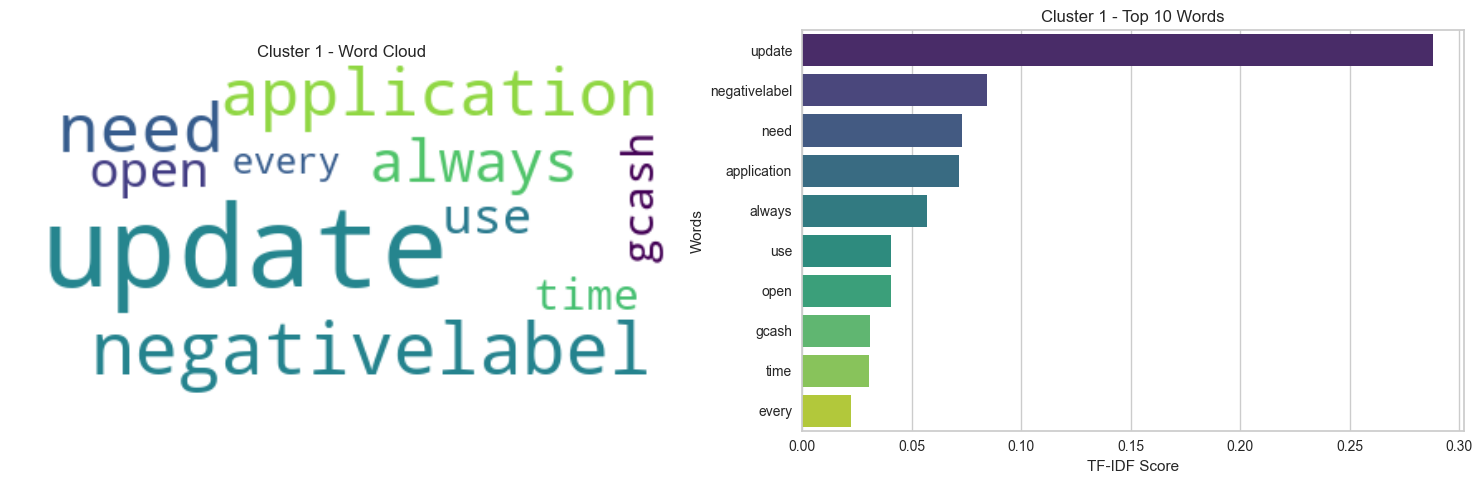

C:\Users\Neil\AppData\Local\Temp\ipykernel_20188\190333237.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=words, ax=axes[1], palette="viridis")


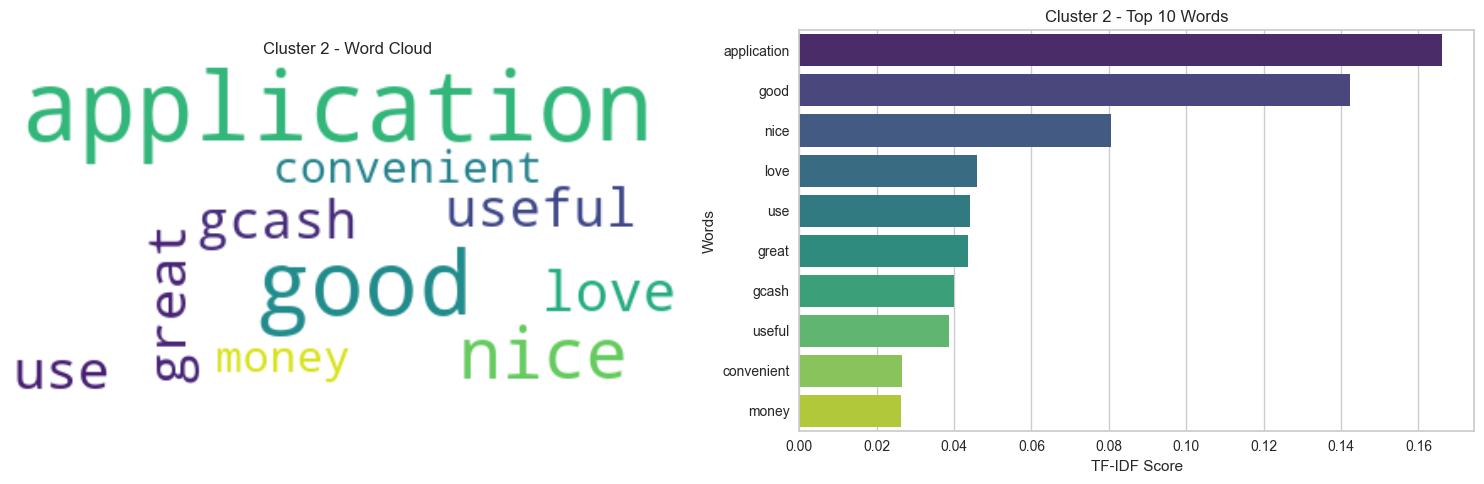

C:\Users\Neil\AppData\Local\Temp\ipykernel_20188\190333237.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=words, ax=axes[1], palette="viridis")


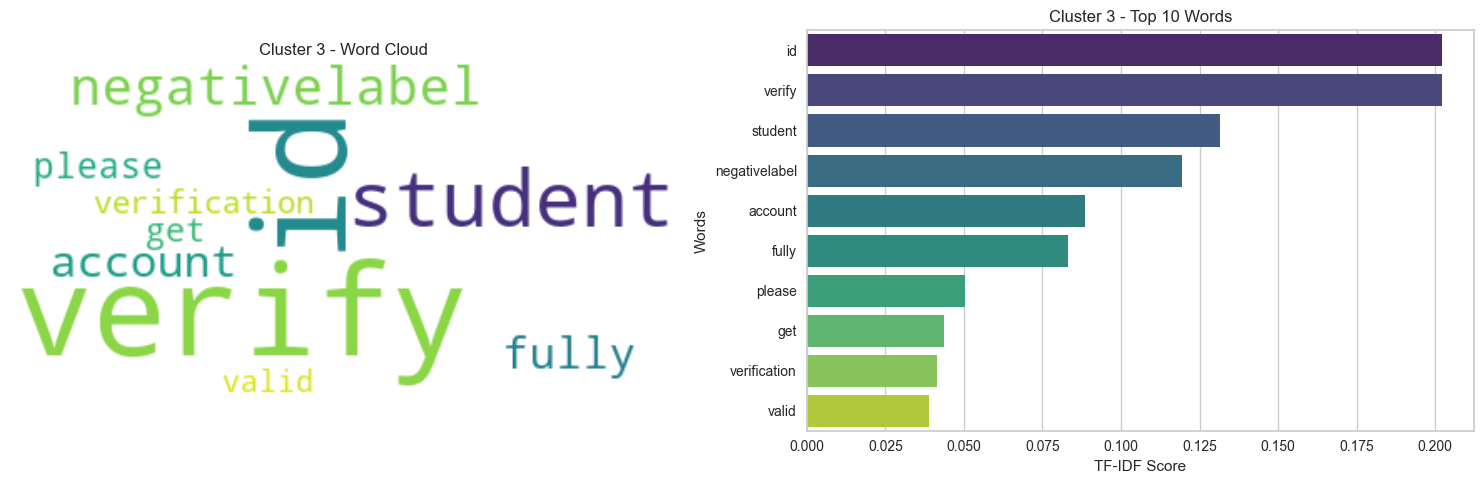

C:\Users\Neil\AppData\Local\Temp\ipykernel_20188\190333237.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=words, ax=axes[1], palette="viridis")


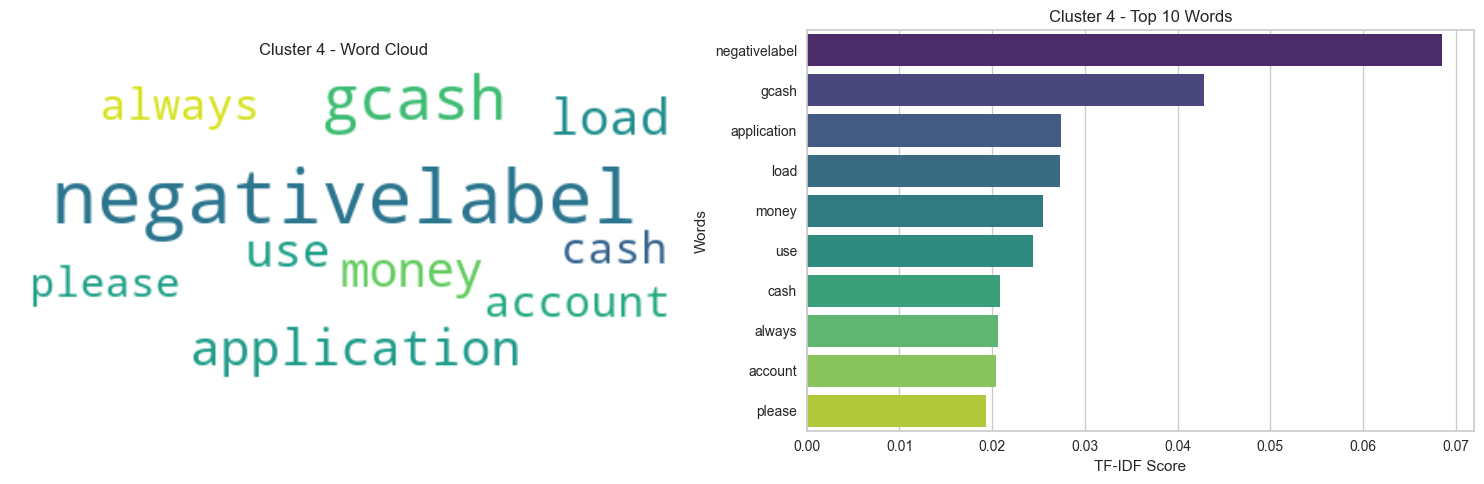

In [176]:
def get_frequencies(cluster_index, top_n=10):
    """Get top words and their scores for a cluster."""
    if cluster_index >= num_clusters:
        return None, None

    term_frequencies = approx_tfidf[cluster_index]
    
    # Get top words
    sorted_indices = np.argsort(term_frequencies)[::-1][:top_n]
    words = [terms[i] for i in sorted_indices]
    scores = [term_frequencies[i] for i in sorted_indices]
    
    frequencies = {terms[i]: term_frequencies[i] for i in sorted_indices}
    
    return words, scores, frequencies

def plot_combined(cluster_index, top_n=10):
    """Plot word cloud & bar chart side by side."""
    words, scores, frequencies = get_frequencies(cluster_index, top_n)
    if words is None:
        return

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Word Cloud
    wc = WordCloud(background_color="white", max_words=top_n)
    wc.generate_from_frequencies(frequencies)
    axes[0].imshow(wc, interpolation="bilinear")
    axes[0].axis("off")
    axes[0].set_title(f"Cluster {cluster_index} - Word Cloud")

    # Bar Chart
    sns.barplot(x=scores, y=words, ax=axes[1], palette="viridis")
    axes[1].set_xlabel("TF-IDF Score")
    axes[1].set_ylabel("Words")
    axes[1].set_title(f"Cluster {cluster_index} - Top {top_n} Words")

    plt.tight_layout()
    plt.show()

# Generate plots for each cluster
for i in range(num_clusters):
    plot_combined(i, top_n=10)

# # Extract feature names (words)
# terms = vectorizer.get_feature_names_out()

# # Ensure df_tfidf is a DataFrame and matches df's shape
# df_tfidf = pd.DataFrame(X, columns=terms)

# # Merge cluster labels from df
# df_tfidf['cluster'] = df['cluster'].values

# # Compute total TF-IDF scores per word in each cluster
# cluster_word_counts = df_tfidf.groupby('cluster').sum()

# def get_frequencies(cluster_index, top_n=10):
#     """Get top words and their scores + total word counts for a cluster."""
#     if cluster_index >= num_clusters:
#         return None, None, None, None

#     # Get term frequencies (TF-IDF sum per word in the cluster)
#     term_frequencies = cluster_word_counts.iloc[cluster_index]

#     # Get top N words based on TF-IDF score
#     sorted_indices = term_frequencies.argsort()[::-1][:top_n]
#     words = [terms[i] for i in sorted_indices]
#     scores = [term_frequencies.iloc[i] for i in sorted_indices]

#     # Get actual word occurrences (raw count)
#     counts = df_tfidf[words].sum().values  # Get word counts for selected words

#     # Dictionary for word cloud
#     frequencies = {words[i]: scores[i] for i in range(len(words))}

#     return words, scores, frequencies, counts

# def plot_combined(cluster_index, top_n=10):
#     """Plot word cloud & bar chart with word counts side by side."""
#     words, scores, frequencies, counts = get_frequencies(cluster_index, top_n)
#     if words is None:
#         return

#     fig, axes = plt.subplots(1, 2, figsize=(15, 5))

#     # Word Cloud
#     wc = WordCloud(background_color="white", max_words=top_n)
#     wc.generate_from_frequencies(frequencies)
#     axes[0].imshow(wc, interpolation="bilinear")
#     axes[0].axis("off")
#     axes[0].set_title(f"Cluster {cluster_index} - Word Cloud")

#     # Bar Chart
#     ax = sns.barplot(x=scores, y=words, ax=axes[1], palette="viridis")

#     # Add text labels for total word counts
#     for i, count in enumerate(counts):
#         ax.text(scores[i], i, f" {int(count)}", va='center', fontsize=10, color='black')

#     axes[1].set_xlabel("TF-IDF Score")
#     axes[1].set_ylabel("Words")
#     axes[1].set_title(f"Cluster {cluster_index} - Top {top_n} Words")

#     plt.tight_layout()
#     plt.show()

# # Generate plots for each cluster
# for i in range(num_clusters):
#     plot_combined(i, top_n=10)

In [177]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans, DBSCAN

# Compute metrics for K-Means
print("K-Means Metrics:")
print("Silhouette Score:", silhouette_score(X_svd, kmeans_labels, metric='euclidean'))
print("Davies-Bouldin Index:", davies_bouldin_score(X_svd, kmeans_labels))
print("Calinski-Harabasz Index:", calinski_harabasz_score(X_svd, kmeans_labels))

K-Means Metrics:
Silhouette Score: 0.020997393513149772
Davies-Bouldin Index: 5.909544890542373
Calinski-Harabasz Index: 343.909365029113


In [178]:
# import umap.umap_ as umap

# # Reduce to 2D using UMAP
# umap_model = umap.UMAP(n_components=2, random_state=42)
# X_2d = umap_model.fit_transform(X_svd)

# # Plot clusters
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=kmeans.labels_, palette='tab10', alpha=0.7)
# plt.xlabel("UMAP Component 1")
# plt.ylabel("UMAP Component 2")
# plt.title("K-Means Clustering Visualization with UMAP")
# plt.legend(title="Cluster")
# plt.show()

In [179]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Convert to DataFrame with only first two components
# df_pca = pd.DataFrame(X_svd[:, :2], columns=['PC1', 'PC2'])
# df_pca['cluster'] = df['cluster']  # Assign KMeans cluster labels

# # Plot using Seaborn
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='PC1', y='PC2', hue='cluster', palette='viridis', data=df_pca, alpha=0.7)
# plt.title("PCA Visualization of KMeans Clusters")
# plt.xlabel("Principal Component 1")
# plt.ylabel("Principal Component 2")
# plt.legend(title='Cluster')
# plt.show()


In [180]:
# plt.figure(figsize=(8,6))
# plt.scatter(X_svd[:,0], X_svd[:,1], c=df['cluster'], cmap='viridis', alpha=0.5)
# plt.colorbar(label="Cluster")
# plt.xlabel("PCA Component 1")
# plt.ylabel("PCA Component 2")
# plt.title("Clusters Visualized using PCA")
# plt.show()

In [181]:
# radius = 0.10
# core_point_samples = 1000

In [182]:
# from sklearn.cluster import DBSCAN

# db_default = DBSCAN(eps=radius, min_samples=core_point_samples).fit(X_svd)
# labels = db_default.labels_

In [183]:
# # Unique labels (clusters + noise)
# unique_labels = set(labels)
# colours = plt.cm.get_cmap("tab10", len(unique_labels))  # Use a colormap

# # Scatter plot with dynamic colors
# plt.figure(figsize=(9, 9))

# for label in unique_labels:
#     cluster_points = X_svd[labels == label]
#     plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
#                 label=f'Cluster {label}' if label != -1 else 'Noise',
#                 alpha=0.6, edgecolors='k')

# plt.xlabel('P1')
# plt.ylabel('P2')
# plt.title('DBSCAN Clustering Visualization')
# plt.legend()
# plt.show()